In [1]:
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
#Libraries

from __future__ import print_function, division
from builtins import range, input
import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization,MaxPool2D
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
import cv2 
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.metrics import classification_report
#Test Train Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [4]:
#define paths
models_path = r"C:/Users/T-x23/Downloads/Mini_project_Covid19/models/"

covid_path =r"C:\Users\T-x23\Downloads\Mini_project_Covid19\data\Chest_COVID"
noncovid_path =r"C:\Users\T-x23\Downloads\Mini_project_Covid19\data\Chest_NonCOVID"


# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [5]:
#Fetch images and Class Labels 
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]


for i in range(len(covid_files)):
    image = cv2.imread(covid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    covid_images.append(image)
    covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
    image = cv2.imread(noncovid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    noncovid_images.append(image)
    noncovid_labels.append('Chest_NonCOVID')


In [6]:
# look at a random image
def plot_images(images, title):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[10,6], facecolor=(1, 1, 1))
    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 0, 0.1])
    plt.show()

C:\Users\T-x23\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  if __name__ == '__main__':


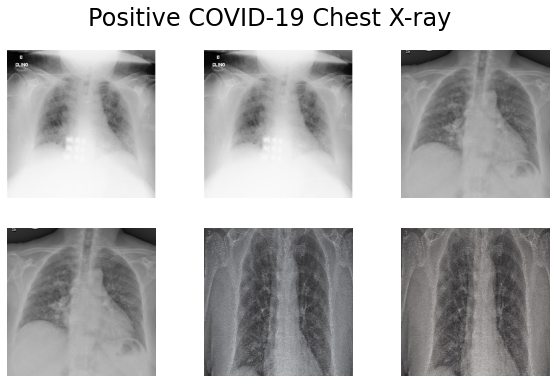

In [7]:
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')

C:\Users\T-x23\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  if __name__ == '__main__':


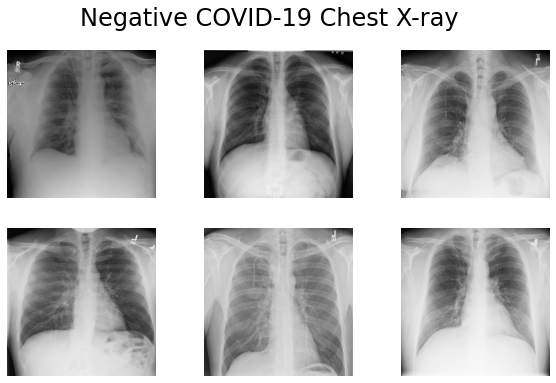

In [8]:
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

In [9]:
#We must do normalization and form of pizels [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [10]:
#Test Train Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [12]:
 

inception = InceptionV3(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)
model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_aug = ImageDataGenerator(rotation_range=20,width_shift_range=0.2,height_shift_range=0.2, horizontal_flip=True)


In [13]:
batch_size=32
epochs =200
#early_stop = EarlyStopping( min_delta=0, patience=50, verbose=1, mode='auto')
#EarlyStopping(monitor='val_loss', mode="min",verbose =1) 
checkpointer = ModelCheckpoint( filepath=models_path+'cnn.h5', verbose=1, save_best_only=True, mode = 'auto')
lr_reducer = ReduceLROnPlateau( factor=0.9, patience=25, verbose=1)

In [18]:

#Train the model
hist = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),validation_data=(X_test, y_test),
                  callbacks=[checkpointer
                            # , early_stop
                             ,lr_reducer],shuffle=True,
                    validation_steps=len(X_test) / batch_size,steps_per_epoch=len(X_train) / 32,epochs=epochs)

Train for 23.5 steps, validate on 188 samples
Epoch 1/200
23/23 [============================>.] - ETA: 0s - loss: 1.4405 - accuracy: 0.6653
Epoch 00001: val_loss improved from inf to 2.21828, saving model to C:/Users/T-x23/Downloads/Mini_project_Covid19/models/cnn.h5
24/23 [==============================] - 15s 623ms/step - loss: 1.4154 - accuracy: 0.6702 - val_loss: 2.2183 - val_accuracy: 0.5851
Epoch 2/200
23/23 [============================>.] - ETA: 0s - loss: 0.9249 - accuracy: 0.7514
Epoch 00002: val_loss improved from 2.21828 to 1.41134, saving model to C:/Users/T-x23/Downloads/Mini_project_Covid19/models/cnn.h5
24/23 [==============================] - 10s 397ms/step - loss: 0.9029 - accuracy: 0.7566 - val_loss: 1.4113 - val_accuracy: 0.6809
Epoch 3/200
23/23 [============================>.] - ETA: 0s - loss: 0.9440 - accuracy: 0.7750
Epoch 00003: val_loss improved from 1.41134 to 0.98970, saving model to C:/Users/T-x23/Downloads/Mini_project_Covid19/models/cnn.h5
24/23 [======

23/23 [============================>.] - ETA: 0s - loss: 1.2610 - accuracy: 0.8569
Epoch 00058: val_loss did not improve from 0.98970
24/23 [==============================] - 10s 435ms/step - loss: 1.2201 - accuracy: 0.8604 - val_loss: 4.7105 - val_accuracy: 0.6702
Epoch 59/200
23/23 [============================>.] - ETA: 0s - loss: 1.0437 - accuracy: 0.8653
Epoch 00059: val_loss did not improve from 0.98970
24/23 [==============================] - 10s 428ms/step - loss: 1.0789 - accuracy: 0.8617 - val_loss: 6.8898 - val_accuracy: 0.6117
Epoch 60/200
23/23 [============================>.] - ETA: 0s - loss: 0.9206 - accuracy: 0.8847
Epoch 00060: val_loss did not improve from 0.98970
24/23 [==============================] - 10s 413ms/step - loss: 0.9022 - accuracy: 0.8870 - val_loss: 4.7973 - val_accuracy: 0.6596
Epoch 61/200
23/23 [============================>.] - ETA: 0s - loss: 0.9552 - accuracy: 0.8556
Epoch 00061: val_loss did not improve from 0.98970
24/23 [======================

23/23 [============================>.] - ETA: 0s - loss: 1.0773 - accuracy: 0.8569
Epoch 00116: val_loss did not improve from 0.98970
24/23 [==============================] - 10s 432ms/step - loss: 1.1275 - accuracy: 0.8564 - val_loss: 5.6836 - val_accuracy: 0.6383
Epoch 117/200
23/23 [============================>.] - ETA: 0s - loss: 1.2045 - accuracy: 0.8639
Epoch 00117: val_loss did not improve from 0.98970
24/23 [==============================] - 10s 431ms/step - loss: 1.2171 - accuracy: 0.8630 - val_loss: 2.9043 - val_accuracy: 0.7234
Epoch 118/200
23/23 [============================>.] - ETA: 0s - loss: 1.2643 - accuracy: 0.8458
Epoch 00118: val_loss did not improve from 0.98970
24/23 [==============================] - 10s 426ms/step - loss: 1.2634 - accuracy: 0.8484 - val_loss: 7.9590 - val_accuracy: 0.5957
Epoch 119/200
23/23 [============================>.] - ETA: 0s - loss: 0.9760 - accuracy: 0.8792
Epoch 00119: val_loss did not improve from 0.98970
24/23 [===================

23/23 [============================>.] - ETA: 0s - loss: 1.2391 - accuracy: 0.8583
Epoch 00145: val_loss did not improve from 0.98970
24/23 [==============================] - 10s 433ms/step - loss: 1.3520 - accuracy: 0.8564 - val_loss: 8.0083 - val_accuracy: 0.6064
Epoch 146/200
23/23 [============================>.] - ETA: 0s - loss: 0.9763 - accuracy: 0.8958
Epoch 00146: val_loss did not improve from 0.98970
24/23 [==============================] - 9s 385ms/step - loss: 1.0274 - accuracy: 0.8936 - val_loss: 5.7690 - val_accuracy: 0.6383
Epoch 147/200
23/23 [============================>.] - ETA: 0s - loss: 1.2086 - accuracy: 0.8597
Epoch 00147: val_loss did not improve from 0.98970
24/23 [==============================] - 10s 406ms/step - loss: 1.2455 - accuracy: 0.8551 - val_loss: 7.5354 - val_accuracy: 0.6170
Epoch 148/200
23/23 [============================>.] - ETA: 0s - loss: 0.9350 - accuracy: 0.8819
Epoch 00148: val_loss did not improve from 0.98970
24/23 [====================

23/23 [============================>.] - ETA: 0s - loss: 0.9723 - accuracy: 0.8944
Epoch 00174: val_loss did not improve from 0.98970
24/23 [==============================] - 10s 428ms/step - loss: 0.9423 - accuracy: 0.8963 - val_loss: 8.7957 - val_accuracy: 0.5851
Epoch 175/200
23/23 [============================>.] - ETA: 0s - loss: 0.8648 - accuracy: 0.8875
Epoch 00175: val_loss did not improve from 0.98970
24/23 [==============================] - 9s 385ms/step - loss: 0.9422 - accuracy: 0.8816 - val_loss: 9.3358 - val_accuracy: 0.5798
Epoch 176/200
23/23 [============================>.] - ETA: 0s - loss: 0.9626 - accuracy: 0.8833
Epoch 00176: val_loss did not improve from 0.98970
24/23 [==============================] - 10s 429ms/step - loss: 1.0087 - accuracy: 0.8830 - val_loss: 10.1887 - val_accuracy: 0.5638
Epoch 177/200
23/23 [============================>.] - ETA: 0s - loss: 1.0959 - accuracy: 0.8514
Epoch 00177: val_loss did not improve from 0.98970
24/23 [===================

In [19]:
model.save(models_path+'inceptionv3.h5')
model.save_weights(models_path+'inceptionv3.hdf5')
model = load_model(models_path+'inceptionv3.h5')

In [20]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=32)
scores

188/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[5.685365254574633, 0.67021275]

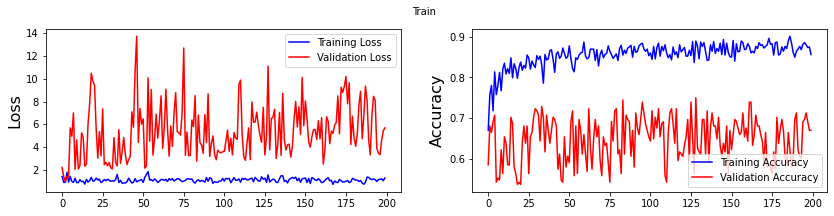

In [21]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Train', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [22]:
#making prediction
y_pred = model.predict(X_test, batch_size=batch_size)

In [23]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=32)
scores

188/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[5.685365254574633, 0.67021275]

In [25]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [29]:
from sklearn.metrics import classification_report
print ('\nClasification(InceptionV3) report:\n', classification_report(y_test_bin, y_pred_bin))


Clasification(InceptionV3) report:
               precision    recall  f1-score   support

           0       0.80      0.38      0.52        87
           1       0.63      0.92      0.75       101

    accuracy                           0.67       188
   macro avg       0.72      0.65      0.63       188
weighted avg       0.71      0.67      0.64       188



Text(0.5, 1.0, 'InceptionV3 Model ')

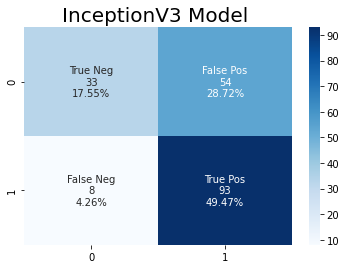

In [30]:
cf_matrix = confusion_matrix(y_test_bin,y_pred_bin)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.title("InceptionV3 Model ", fontsize =20)